In [1]:
%matplotlib inline

# Dependencies

This notebook depends on the most recent development version of (slabbe)[https://pypi.python.org/pypi/slabbe] Optional Sage Package. The latest release can be installed with `sage -pip install slabbe`.

This notebook depends on the use of Glucose as a Sage optional package: https://trac.sagemath.org/ticket/26361

In [2]:
from slabbe import WangTileSet

# Jeandel-Rao's 11 Wang tiles

We construct Jeandel-Rao's set of Wang tiles $T_0$ as well at tile sets $T_2$ and $T_3$ from https://arxiv.org/abs/1808.07768

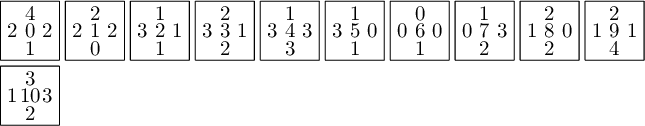

In [3]:
tiles = [(2,4,2,1), (2,2,2,0), (1,1,3,1), (1,2,3,2), (3,1,3,3), 
         (0,1,3,1), (0,0,0,1), (3,1,0,2), (0,2,1,2), (1,2,1,4), (3,3,1,2)]
T0 = WangTileSet([map(str,t) for t in tiles])
T0.tikz()

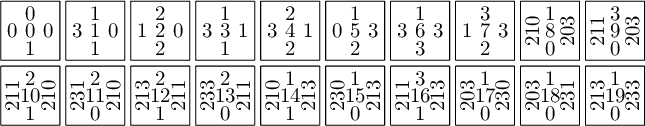

In [4]:
tiles = [(0, 0, 0, 1), (0, 1, 3, 1), (0, 2, 1, 2), (1, 1, 3, 1), (1, 2, 3, 2), (3, 1, 0, 2), (3, 1, 3, 3), (3, 3, 1, 2),
 (203, 1, 210, 0), (203, 3, 211, 0), (210, 2, 211, 1), (210, 2, 231, 0), (211, 2, 213, 1),
 (211, 2, 233, 0), (213, 1, 210, 1), (213, 1, 230, 0), (213, 3, 211, 1), (230, 1, 203, 0), 
 (231, 1, 203, 0), (233, 1, 213, 0)]
T2 = WangTileSet([map(str,t) for t in tiles])
T2.tikz()

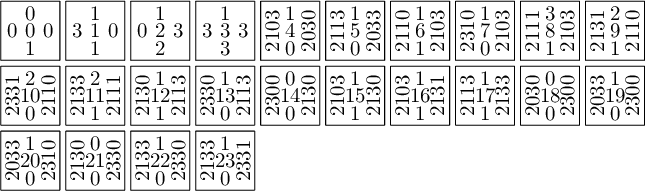

In [5]:
tiles = [(0, 0, 0, 1), (0, 1, 3, 1), (3, 1, 0, 2), (3, 1, 3, 3), (2030, 1, 2103, 0), (2033, 1, 2113, 0),
 (2103, 1, 2110, 1), (2103, 1, 2310, 0), (2103, 3, 2111, 1), (2110, 2, 2131, 1), (2110, 2, 2331, 0), (2111, 2, 2133, 1),
 (2113, 1, 2130, 1), (2113, 1, 2330, 0), (2130, 0, 2300, 0), (2130, 1, 2103, 1), (2131, 1, 2103, 1), (2133, 1, 2113, 1),
 (2300, 0, 2030, 0), (2300, 1, 2033, 0), (2310, 1, 2033, 0), (2330, 0, 2130, 0), (2330, 1, 2133, 0), (2331, 1, 2133, 0)]
T3 = WangTileSet([map(str,t) for t in tiles])
T3.tikz()

# Tiling a 3x3 square with Wang tiles

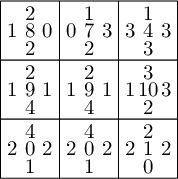

In [6]:
tiling = T0.solver(3,3).solve(solver='Coin')
tiling.tikz()

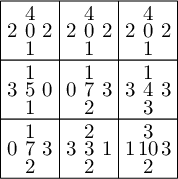

In [7]:
tiling = T0.solver(3,3).solve(solver='glucose')
tiling.tikz()

## Reduction to SAT:
The reduction to SAT of the tiling of a $n\times n$ square by $t$ Wang tiles needs $t\times n^2$ variables and at most $2n^2 t^2$ constraints.

In [8]:
for k in range(10,70,10):
    print k, T0.solver(k,k).sat_solver('cryptominisat')

10 CryptoMiniSat solver: 1100 variables, 21440 clauses.
20 CryptoMiniSat solver: 4400 variables, 89280 clauses.
30 CryptoMiniSat solver: 9900 variables, 203520 clauses.
40 CryptoMiniSat solver: 17600 variables, 364160 clauses.
50 CryptoMiniSat solver: 27500 variables, 571200 clauses.
60 CryptoMiniSat solver: 39600 variables, 824640 clauses.


## Reduction to MILP
The reduction to MILP of the tiling of a $n\times n$ square needs $11\times n^2$ variables and $2n(n-1)+n^2$ constraints.

In [9]:
for k in range(10,70,10):
    print k, T0.solver(k,k).milp()

10 (Boolean Program (maximization, 1100 variables, 280 constraints), MIPVariable of dimension 1)
20 (Boolean Program (maximization, 4400 variables, 1160 constraints), MIPVariable of dimension 1)
30 (Boolean Program (maximization, 9900 variables, 2640 constraints), MIPVariable of dimension 1)
40 (Boolean Program (maximization, 17600 variables, 4720 constraints), MIPVariable of dimension 1)
50 (Boolean Program (maximization, 27500 variables, 7400 constraints), MIPVariable of dimension 1)
60 (Boolean Program (maximization, 39600 variables, 10680 constraints), MIPVariable of dimension 1)


# Finding a nxn valid Wang square tiling : comparing solvers

In [10]:
import time,signal
def time_solving_squares(wang_tile_set, solver='gurobi', maxsize=1000, step=1, timelimit=5, verbose=False):
    r"""
    Return a list of tuples (n,t) where t is the time spent (in seconds) finding 
    a valid Wang tiling of the n times n square.
    
    EXAMPLES::
    
        sage: time_solving_squares(solver='gurobi', timelimit=1)
        [(1, 0.0019371509552001953),
         (2, 0.004050016403198242),
         (3, 0.01121377944946289),
         (4, 0.015249013900756836),
         (5, 0.0812530517578125),
         (6, 0.08473992347717285),
         (7, 0.23214101791381836),
         (8, 0.33846092224121094),
         (9, 0.6193099021911621),
         (10, 1)]
    """
    L = []
    for i in range(1, maxsize, step):
        try:
            signal.alarm(timelimit)
            start = time.time()
            solution = wang_tile_set.solver(i,i).solve(solver=solver, ncpus=8)
            end = time.time()
        except (AlarmInterrupt, ValueError): # dancing_links catches the alarm and returns valueError
            L.append( (i,timelimit) )
            break
        else:
            signal.alarm(0)    # cancels the alarm
        duration = end - start
        L.append( (i,duration) )
        if verbose:
            print( (i,duration) )
    return L

Testing:

In [11]:
time_solving_squares(T0, solver='Gurobi', timelimit=1)

[(1, 0.0034780502319335938),
 (2, 0.00877690315246582),
 (3, 0.013873100280761719),
 (4, 0.020534038543701172),
 (5, 0.16086292266845703),
 (6, 0.08809590339660645),
 (7, 0.2522618770599365),
 (8, 0.38977479934692383),
 (9, 0.7161390781402588),
 (10, 1)]

In [12]:
import pandas as pd
def compare_solvers(wang_tile_set, solvers, maxsize=1000, step=1, timelimit=5):
    wang_tile_set = WangTileSet(list(wang_tile_set)) # reinitialize cached values
    series_dict = {}
    for solver in solvers:
        print('Testing solver {} ...'.format(solver))
        L = time_solving_squares(wang_tile_set, solver=solver, maxsize=maxsize, step=step, timelimit=timelimit)
        index,data = zip(*L)
        series = pd.Series(data=data, index=index, dtype=float)
        series_dict[solver] = series
        print('    -> solved {} instances'.format(len(series)))
    sorted_solvers = sorted(solvers, key=lambda solver:len(series_dict[solver]))
    return pd.DataFrame(series_dict, columns=sorted_solvers)

Define the list of solvers:

In [13]:
LPsolvers = ['Gurobi', 'LP']
slowLPsolvers = ['GLPK', 'PPL']
SATsolvers = ['cryptominisat', 'picosat', 'glucose']
uninstalled = ['Coin', 'GLPK/exact', 'CPLEX', 'CVXOPT', 'rsat']  # to be added to the comparison one day
solvers = slowLPsolvers + SATsolvers + LPsolvers + ['dancing_links']

In [14]:
df_square_T0 = compare_solvers(T0, solvers, timelimit=10)

Testing solver GLPK ...
    -> solved 7 instances
Testing solver PPL ...
    -> solved 5 instances
Testing solver cryptominisat ...
    -> solved 42 instances
Testing solver picosat ...
    -> solved 37 instances
Testing solver glucose ...
    -> solved 56 instances
Testing solver Gurobi ...
    -> solved 13 instances
Testing solver LP ...
    -> solved 15 instances
Testing solver dancing_links ...
    -> solved 23 instances


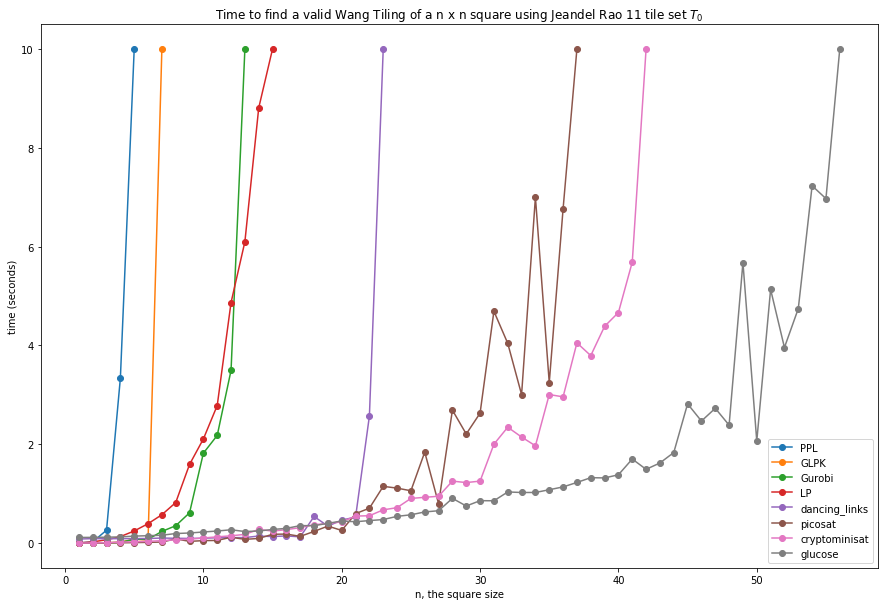

In [41]:
ax = df_square_T0.plot(figsize=(15,10), marker='o')
ax.set(xlabel="n, the square size", ylabel="time (seconds)", 
       title='Time to find a valid Wang Tiling of a n x n square using Jeandel Rao 11 tile set $T_0$')
ax.get_figure().savefig('T0_square_tilings.svg')

In [16]:
df_square_T2 = compare_solvers(T2, solvers, timelimit=10)

Testing solver GLPK ...
    -> solved 6 instances
Testing solver PPL ...
    -> solved 4 instances
Testing solver cryptominisat ...
    -> solved 35 instances
Testing solver picosat ...
    -> solved 24 instances
Testing solver glucose ...
    -> solved 39 instances
Testing solver Gurobi ...
    -> solved 11 instances
Testing solver LP ...
    -> solved 11 instances
Testing solver dancing_links ...
    -> solved 22 instances


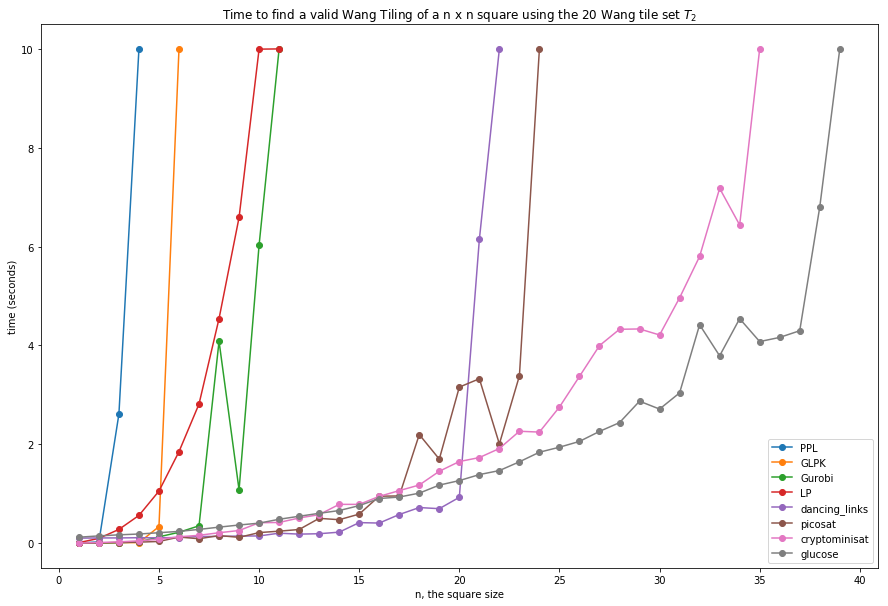

In [42]:
ax = df_square_T2.plot(figsize=(15,10), marker='o')
ax.set(xlabel="n, the square size", ylabel="time (seconds)", 
       title='Time to find a valid Wang Tiling of a n x n square using the 20 Wang tile set $T_2$')
ax.get_figure().savefig('T2_square_tilings.svg')

In [18]:
df_square_T3 = compare_solvers(T3, solvers, timelimit=10)

Testing solver GLPK ...
    -> solved 6 instances
Testing solver PPL ...
    -> solved 4 instances
Testing solver cryptominisat ...
    -> solved 24 instances
Testing solver picosat ...
    -> solved 27 instances
Testing solver glucose ...
    -> solved 35 instances
Testing solver Gurobi ...
    -> solved 11 instances
Testing solver LP ...
    -> solved 9 instances
Testing solver dancing_links ...
    -> solved 16 instances


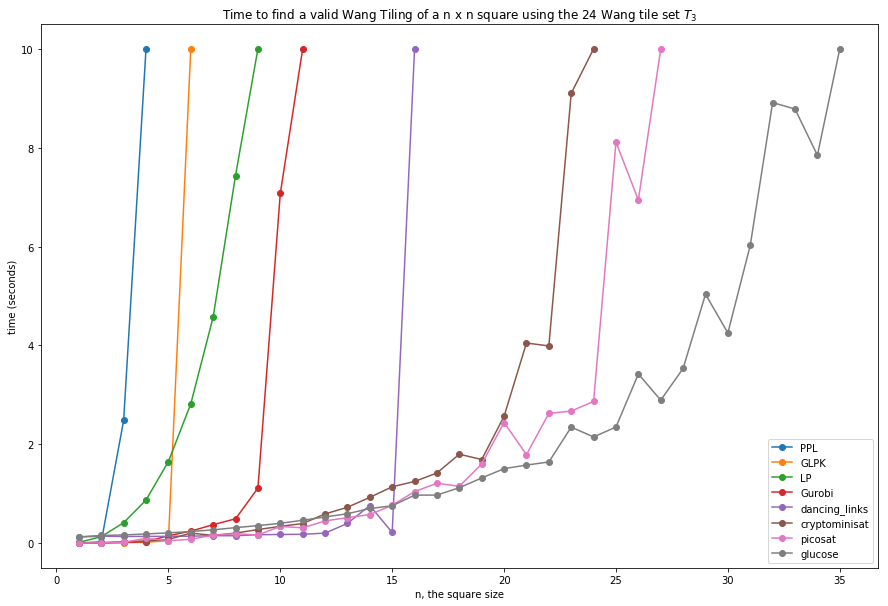

In [43]:
ax = df_square_T3.plot(figsize=(15,10), marker='o')
ax.set(xlabel="n, the square size", ylabel="time (seconds)",
       title='Time to find a valid Wang Tiling of a n x n square using the 24 Wang tile set $T_3$')
ax.get_figure().savefig('T3_square_tilings.svg')

# Finding all dominoes admitting a surrounding : comparing solvers

In [20]:
import time,signal
def time_finding_dominoes(wang_tile_set, solver='gurobi', radius_list=[1,2,3], timelimit=5, verbose=False):
    r"""
    EXAMPLES::
    
        sage: time_finding_dominoes(solver='gurobi', timelimit=30)
        [(1, 2.8133392333984375e-05),
         (2, 1.2874603271484375e-05),
         (3, 5.506983995437622),
         (4, 10.366616010665894),
         (5, 20.101346015930176),
         (6, 30)]
    """
    L = []
    for radius in radius_list:
        try:
            signal.alarm(timelimit)
            start = time.time()
            dominoes = {}
            for direction in [1, 2]:
                dominoes[direction] = wang_tile_set.dominoes_with_surrounding(radius=radius, i=direction, solver=solver, ncpus=1)
                if verbose:
                    print('{} computes {} dominoes in the direction e{} with'
                          ' surrounding radius {}'.format(solver, len(dominoes[direction]), direction, radius))
            end = time.time()
        except (AlarmInterrupt, ValueError): # dancing_links catches the alarm and returns valueError
            #L.append( (radius,timelimit, None, None) )
            break
        else:
            signal.alarm(0)    # cancels the alarm
        duration = end - start
        L.append( (radius,duration,len(dominoes[1]), len(dominoes[2]) ) )
        if verbose:
            print('Computation time for radius {}: {} seconds'.format(radius,duration))
    return L

In [21]:
time_finding_dominoes(T2, solver='dancing_links', verbose=True, timelimit=10)

dancing_links computes 38 dominoes in the direction e1 with surrounding radius 1
dancing_links computes 64 dominoes in the direction e2 with surrounding radius 1
Computation time for radius 1: 1.491492033 seconds
dancing_links computes 35 dominoes in the direction e1 with surrounding radius 2
dancing_links computes 50 dominoes in the direction e2 with surrounding radius 2
Computation time for radius 2: 4.06505918503 seconds
dancing_links computes 35 dominoes in the direction e1 with surrounding radius 3


[(1, 1.4914920330047607, 38, 64), (2, 4.065059185028076, 35, 50)]

In [22]:
time_finding_dominoes(T2, solver='picosat', verbose=True, timelimit=100)

picosat computes 38 dominoes in the direction e1 with surrounding radius 1
picosat computes 64 dominoes in the direction e2 with surrounding radius 1
Computation time for radius 1: 14.2032501698 seconds
picosat computes 35 dominoes in the direction e1 with surrounding radius 2
picosat computes 50 dominoes in the direction e2 with surrounding radius 2
Computation time for radius 2: 41.7534508705 seconds
picosat computes 35 dominoes in the direction e1 with surrounding radius 3
picosat computes 50 dominoes in the direction e2 with surrounding radius 3
Computation time for radius 3: 82.6413869858 seconds


[(1, 14.203250169754028, 38, 64),
 (2, 41.753450870513916, 35, 50),
 (3, 82.64138698577881, 35, 50)]

In [23]:
import pandas as pd
def compare_solvers_for_dominoes(wang_tile_set, solvers, radius_list=[1,2,3], timelimit=5, verbose=False):
    wang_tile_set = WangTileSet(list(wang_tile_set)) # reinitialize cached values
    series_dict = {}
    for solver in solvers:
        print('Testing solver {} ...'.format(solver))
        L = time_finding_dominoes(wang_tile_set, solver=solver, radius_list=radius_list, 
                                  timelimit=timelimit, verbose=verbose)
        if L:
            index,data,dir1,dir2 = zip(*L)
            print('    -> Found {} and {} dominoes in the direction'
                  ' 1 and 2 resp for radius in {}'.format(dir1, dir2, radius_list))
            print('    -> time data: {}'.format(data))
        else:
            index = []
            data = []
        series = pd.Series(data=data, index=index, dtype=float)
        series_dict[solver] = series
    sorted_solvers = sorted(solvers, key=lambda solver:len(series_dict[solver]))
    return pd.DataFrame(series_dict, columns=sorted_solvers)

In [24]:
solvers = ['dancing_links'] + SATsolvers + LPsolvers # + slowLPsolvers
timelimit = 1000

In [25]:
df_dominoes_T0 = compare_solvers_for_dominoes(T0, solvers, radius_list=[1,2,3], timelimit=timelimit)
df_dominoes_T0

Testing solver dancing_links ...
    -> Found (27, 27, 27) and (30, 29, 29) dominoes in the direction 1 and 2 resp for radius in [1, 2, 3]
    -> time data: (0.2731480598449707, 0.6504981517791748, 1.2540009021759033)
Testing solver cryptominisat ...
    -> Found (27, 27, 27) and (30, 29, 29) dominoes in the direction 1 and 2 resp for radius in [1, 2, 3]
    -> time data: (1.4911208152770996, 4.444904804229736, 9.103967905044556)
Testing solver picosat ...
    -> Found (27, 27, 27) and (30, 29, 29) dominoes in the direction 1 and 2 resp for radius in [1, 2, 3]
    -> time data: (1.0466749668121338, 3.2454769611358643, 6.970124959945679)
Testing solver glucose ...
    -> Found (27, 27, 27) and (30, 29, 29) dominoes in the direction 1 and 2 resp for radius in [1, 2, 3]
    -> time data: (36.92062783241272, 38.37336015701294, 42.61258316040039)
Testing solver Gurobi ...
    -> Found (27, 27, 27) and (30, 29, 29) dominoes in the direction 1 and 2 resp for radius in [1, 2, 3]
    -> time da

dancing_links  cryptominisat   picosat    glucose    Gurobi          LP
1       0.273148       1.491121  1.046675  36.920628  1.290088   24.050107
2       0.650498       4.444905  3.245477  38.373360  2.865947   71.829919
3       1.254001       9.103968  6.970125  42.612583  5.688136  159.424144

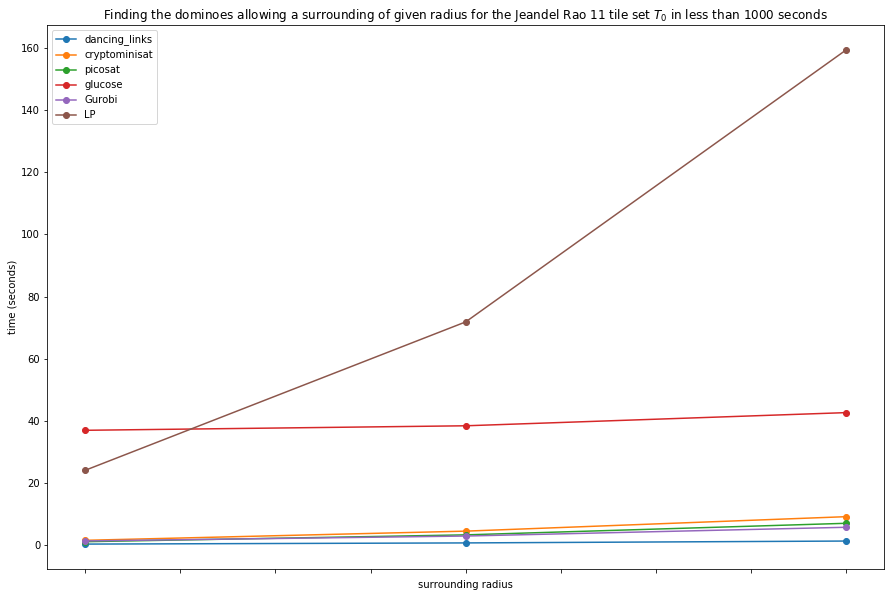

In [44]:
ax = df_dominoes_T0.plot(figsize=(15,10), marker='o')
ax.set(xlabel="surrounding radius", ylabel="time (seconds)", 
       title='Finding the dominoes allowing a surrounding of given radius '
             'for the Jeandel Rao 11 tile set $T_0$ in less than {} seconds'.format(timelimit))
ax.get_figure().savefig('T0_dominoes_surrounding.svg')

In [27]:
df_dominoes_T2 = compare_solvers_for_dominoes(T2, solvers, radius_list=[1,2,3], timelimit=timelimit)
df_dominoes_T2

Testing solver dancing_links ...
    -> Found (38, 35, 35) and (64, 50, 50) dominoes in the direction 1 and 2 resp for radius in [1, 2, 3]
    -> time data: (1.4719769954681396, 3.9624440670013428, 10.121387004852295)
Testing solver cryptominisat ...
    -> Found (38, 35, 35) and (64, 50, 50) dominoes in the direction 1 and 2 resp for radius in [1, 2, 3]
    -> time data: (17.726919889450073, 50.687167167663574, 101.87277793884277)
Testing solver picosat ...
    -> Found (38, 35, 35) and (64, 50, 50) dominoes in the direction 1 and 2 resp for radius in [1, 2, 3]
    -> time data: (15.524392127990723, 44.47639989852905, 86.34836101531982)
Testing solver glucose ...
    -> Found (38, 35, 35) and (64, 50, 50) dominoes in the direction 1 and 2 resp for radius in [1, 2, 3]
    -> time data: (128.16299200057983, 153.79267597198486, 190.46218085289001)
Testing solver Gurobi ...
    -> Found (38, 35, 35) and (64, 50, 50) dominoes in the direction 1 and 2 resp for radius in [1, 2, 3]
    -> tim

LP  dancing_links  cryptominisat    picosat     glucose     Gurobi
1  309.004118       1.471977      17.726920  15.524392  128.162992   5.814908
2         NaN       3.962444      50.687167  44.476400  153.792676  13.985904
3         NaN      10.121387     101.872778  86.348361  190.462181  30.073442

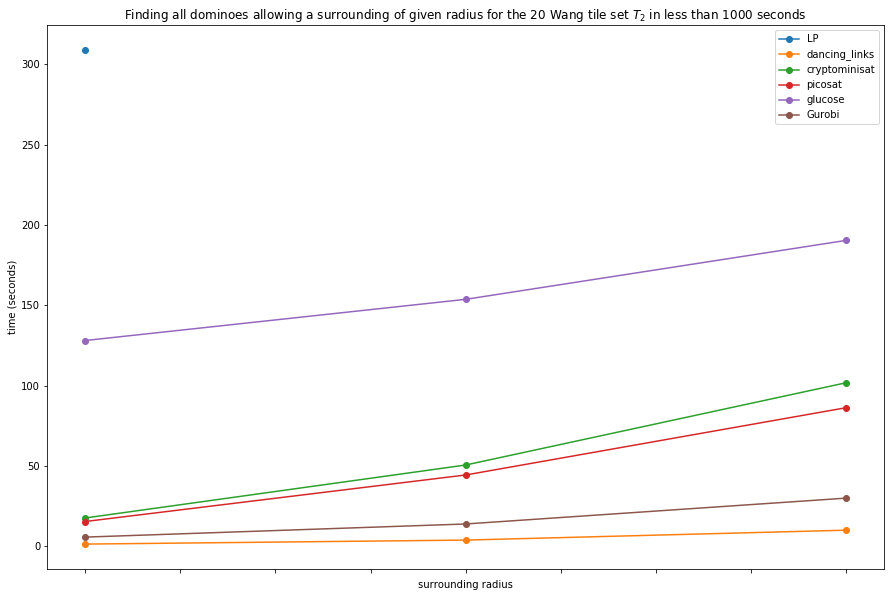

In [45]:
ax = df_dominoes_T2.plot(figsize=(15,10), marker='o')
ax.set(xlabel="surrounding radius", ylabel="time (seconds)", 
       title='Finding all dominoes allowing a surrounding of given radius '
             'for the 20 Wang tile set $T_2$ in less than {} seconds'.format(timelimit))
ax.get_figure().savefig('T2_dominoes_surrounding.svg')

In [29]:
df_dominoes_T3 = compare_solvers_for_dominoes(T3, solvers, radius_list=[1,2,3], timelimit=timelimit)
df_dominoes_T3

Testing solver dancing_links ...
    -> Found (37, 36, 36) and (150, 135, 122) dominoes in the direction 1 and 2 resp for radius in [1, 2, 3]
    -> time data: (2.529252052307129, 6.617175102233887, 14.96087908744812)
Testing solver cryptominisat ...
    -> Found (37, 36, 36) and (150, 135, 122) dominoes in the direction 1 and 2 resp for radius in [1, 2, 3]
    -> time data: (34.189846992492676, 96.47961091995239, 188.86419200897217)
Testing solver picosat ...
    -> Found (37, 36, 36) and (150, 135, 122) dominoes in the direction 1 and 2 resp for radius in [1, 2, 3]
    -> time data: (29.82133984565735, 86.3204460144043, 170.14684510231018)
Testing solver glucose ...
    -> Found (37, 36, 36) and (150, 135, 122) dominoes in the direction 1 and 2 resp for radius in [1, 2, 3]
    -> time data: (197.3815038204193, 242.88399982452393, 312.44361782073975)
Testing solver Gurobi ...
    -> Found (37, 36, 36) and (150, 135, 122) dominoes in the direction 1 and 2 resp for radius in [1, 2, 3]
 

LP  dancing_links  cryptominisat     picosat     glucose     Gurobi
1  659.592004       2.529252      34.189847   29.821340  197.381504   9.465283
2         NaN       6.617175      96.479611   86.320446  242.884000  24.315946
3         NaN      14.960879     188.864192  170.146845  312.443618  55.834558

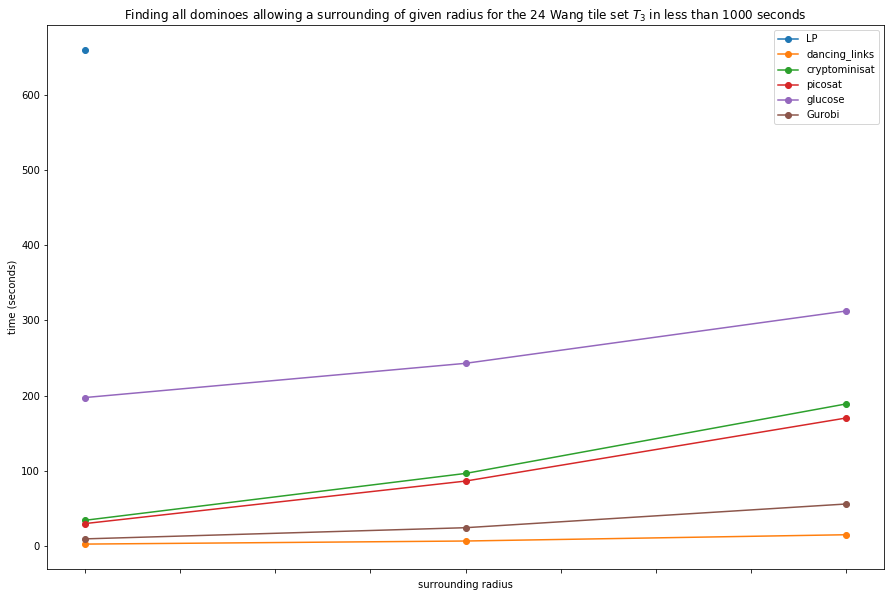

In [46]:
ax = df_dominoes_T3.plot(figsize=(15,10), marker='o')
ax.set(xlabel="surrounding radius", ylabel="time (seconds)", 
       title='Finding all dominoes allowing a surrounding of given radius '
             'for the 24 Wang tile set $T_3$ in less than {} seconds'.format(timelimit))
ax.get_figure().savefig('T3_dominoes_surrounding.svg')